# Sentiment Analysis

    # Name : Kumar Shubham
    # G    : G01402581
    # Netid: kfnu

In [1]:
import numpy as np
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
from nltk.tokenize import word_tokenize
nltk.download("stopwords")
from nltk.corpus import stopwords 
from nltk.stem import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\SHUBHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\SHUBHAM\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Data Cleanup

In [2]:
def csv_to_df(file_name,col_name):
    return pd.read_csv(file_name,delimiter='\t',header=None,names=col_name,index_col=None,quotechar='"',quoting=0,escapechar=None,doublequote=True,delim_whitespace=False,encoding='utf-8')

def data_cleaning(col):
    lower_replace= str(col).lower().replace('\\n',' ').replace('\\',' ')
    rm_numbers= re.sub(r'\d+',' ', lower_replace) 
    translator= str.maketrans(' ', ' ', string.punctuation)
    rm_punctuation= rm_numbers.translate(translator)
    rm_whitespace= " ".join(rm_punctuation.split())
    return rm_whitespace

def rm_stopwords(col):
    stopword_list = stopwords.words("english")
    col_tokens= word_tokenize(col)
    col_tokens= [token.strip() for token in col_tokens]
    clean_tokens= [token for token in col_tokens if token.lower() not in stopword_list]    
    return " ".join(clean_tokens)

def stem_words(col):
    snowballstemmer= SnowballStemmer(language='english')
    stem= " ".join([snowballstemmer.stem(word) for word in col.split()])
    return stem

def data_preprocess(df,col):
    clean= list(map(data_cleaning,df[col]))
    #stopwords= list(map(rm_stopwords,clean))
    stem= list(map(stem_words,clean))
    return stem

In [3]:
#filepath='D:/George Mason/SecondSem/CS584/' 
filepath=''
train_filename=filepath+'reviews_train_file.dat'
train_fileheader=['Sentiment', 'Reviews']
test_filename=filepath+'reviews_test_file.dat'
test_fileheader=['Reviews']

train_df= csv_to_df(train_filename,train_fileheader)
#test_df= csv_to_df(test_filename,test_fileheader)

In [4]:
train_df.Sentiment.value_counts()

 1    10000
-1     8506
Name: Sentiment, dtype: int64

In [5]:
with open(test_filename,'rt',encoding='utf-8') as f:
    test_data = f.read()

In [6]:
test_df = test_data.split('\n')

In [7]:
test_df = pd.DataFrame(test_df,columns=['Reviews']).dropna(how='any',axis=0).drop(18506)

In [8]:
test_df.shape

(18506, 1)

In [9]:
print("Train Dataframe shape:", train_df.shape)
print("Test Dataframe shape:", test_df.shape)

Train Dataframe shape: (18506, 2)
Test Dataframe shape: (18506, 1)


In [10]:
#train and test dataset after using data cleanup
#train_preprocess_w_dc=data_preprocess(train_df,'Reviews')
#test_preprocess_w_dc=data_preprocess(test_df,'Reviews')

In [11]:
label = [i for i in train_df.Sentiment]
reviews = [str(i) for i in train_df.Reviews]

In [12]:
test_reviews = [str(i) for i in test_df.Reviews]

### Text Analysis

In [13]:
#finding out the 10 most common words
words = Counter()
for i in reviews:
  for j in str(i).split(' '):
    words[j] += 1
    
words.most_common(10)

[('the', 86030),
 ('and', 52506),
 ('to', 52332),
 ('I', 49532),
 ('a', 41183),
 ('it', 37114),
 ('', 36580),
 ('is', 28262),
 ('of', 24162),
 ('for', 22760)]

In [14]:
count = CountVectorizer(analyzer='word',ngram_range=(1,2))
#train_cv_w_dc = count.fit_transform(train_preprocess_w_dc)
#test_cv_w_dc = count.transform(test_preprocess_w_dc)
train_cv = count.fit_transform(reviews)
test_cv = count.transform(test_reviews)

tfidf=TfidfTransformer(sublinear_tf=True)
#train_tfidf_w_dc=tfidf.fit_transform(train_cv_w_dc)
#test_tfidf_w_dc=tfidf.transform(test_cv_w_dc)
train_tfidf=tfidf.fit_transform(train_cv)
test_tfidf=tfidf.transform(test_cv)

### Train Test Split 

In [15]:
#training data with tfidf
X=train_tfidf

#training data with data cleaned and tfidf
#X_w_dc=train_tfidf_w_dc

#training data without tfidf
#X_wo_tfidf=train_cv

y=[i for i in train_df['Sentiment']]

#for model-1
#X_train_w_dc, X_test_w_dc, y_train_w_dc, y_test_w_dc = train_test_split(X_w_dc,y,test_size=0.3,random_state=0,stratify=y)

#for model-2
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=0,stratify=y)

#for model-3
#X_train_wo_tfidf, X_test_wo_tfidf, y_train_wo_tfidf, y_test_wo_tfidf = train_test_split(X_wo_tfidf,y,test_size=0.3,random_state=0,stratify=y)

### Logistic Regression 

I am using Liblinear solver in Logistic Regression, which uses popular coordinate descent algorithm (it finds the coefficients of the logistic regression model that minimize the loss function).

And After doing many hit and trial, I found my model accuracy is getting increased by 1% on choosing argument C value using 10-fold cross validation.

To do this, I am looping over the values of C and for each value, I'm training LR model using 10-fold cross-validation.
After that I am storing the average cross-validation score for each value of C. 

In the final step, I find the value of C that leads to the highest cross-validation score, and train a final logistic regression model using that value of C on the training data.

Also, here I am trying to show three models 
(commenting out model-1 and model-3 because of low accuracy as compared to model-2): 

model-1 is trained on cleaned, count vectorized, tfidf transformed data,

model-2 is only trained on count vectorized, tfidf transformed data and 

model-3 is trained without using tfidf.

In [16]:
#Logistic Model 1

# c_val = np.logspace(-3, 3, 7)
# cv_sc = []

# for i in c_val:
#     model = LogisticRegression(C=i, solver='liblinear')
#     sc = cross_val_score(model, X_train_w_dc, y_train_w_dc, cv=10)
#     cv_sc.append(np.mean(sc))

# c_val_final = c_val[np.argmax(cv_sc)]

# model_w_dc=LogisticRegression(C=c_val_final, solver='liblinear')
# model_w_dc.fit(X_train_w_dc, y_train_w_dc)

# test_score_w_dc = model_w_dc.score(X_test_w_dc, y_test_w_dc)
# print(test_score_w_dc)

In [17]:
#result of model 1

# test_pred_w_dc=model_w_dc.predict(X_test_w_dc) 

# print("Classification Report")
# print("=====================")
# print(classification_report(y_test_w_dc, test_pred_w_dc))
# print("\n")
# print("Accuracy Score")
# print("==============")
# print(accuracy_score(y_test, test_pred_w_dc))
# print("\n")
# cm = confusion_matrix(y_test, test_pred_w_dc)
# ax = plt.axes()
# sns.heatmap(cm, annot=True, fmt="d")
# ax.set_title('Confusion matrix Logistic Regression')

In [18]:
#Logistic Model 2

c_val = np.logspace(-3, 3, 7)
cv_sc = []

for i in c_val:
    model = LogisticRegression(C=i, solver='liblinear')
    sc = cross_val_score(model, X_train, y_train, cv=10)
    cv_sc.append(np.mean(sc))

c_val_final = c_val[np.argmax(cv_sc)]

model2=LogisticRegression(C=c_val_final, solver='liblinear')
model2.fit(X_train, y_train)

test_score = model2.score(X_test, y_test)
print(test_score)

0.9052593659942363


In [19]:
c_val_final

100.0

Classification Report
              precision    recall  f1-score   support

          -1       0.90      0.89      0.90      2552
           1       0.91      0.92      0.91      3000

    accuracy                           0.91      5552
   macro avg       0.91      0.90      0.90      5552
weighted avg       0.91      0.91      0.91      5552



Accuracy Score
0.9052593659942363




Text(0.5, 1.0, 'Confusion matrix - Logistic Regression')

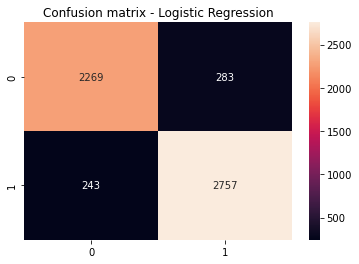

In [20]:
#result of model 2
#predicting test data using model 2
final_test_pred=model2.predict(X_test)

print("Classification Report")
print("=====================")
print(classification_report(y_test, final_test_pred))
print("\n")
print("Accuracy Score")
print("==============")
print(accuracy_score(y_test, final_test_pred))
print("\n")
cm = confusion_matrix(y_test, final_test_pred)
ax = plt.axes()
sns.heatmap(cm, annot=True, fmt="d")
ax.set_title('Confusion matrix - Logistic Regression')

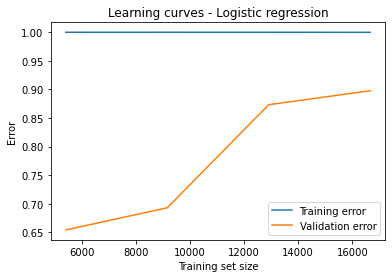

In [21]:
# Use the learning_curve function to get the training and testing scores
train_sizes, train_scores, validation_scores = learning_curve(model2, X, y, cv=10, scoring='accuracy')

train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, validation_scores_mean, label='Validation error')
plt.legend()
plt.xlabel('Training set size')
plt.ylabel('Error')
plt.title('Learning curves - Logistic regression')
plt.show()

In [22]:
#Logistic Model 3

# c_val = np.logspace(-3, 3, 7)
# cv_sc = []

# for i in c_val:
#     model = LogisticRegression(C=i, solver='liblinear')
#     sc = cross_val_score(model, X_train_wo_tfidf, y_train_wo_tfidf, cv=10)
#     cv_sc.append(np.mean(sc))

# c_val_final = c_val[np.argmax(cv_sc)]

# model3=LogisticRegression(C=c_val_final, solver='liblinear')
# model3.fit(X_train_wo_tfidf, y_train_wo_tfidf)

# test_score3 = model3.score(X_test_wo_tfidf, y_test_wo_tfidf)
# print(test_score3)

In [23]:
#result of model 3

# final_test_pred=best_model.predict(X_test_wo_tfidf)

# print("Classification Report")
# print("=====================")
# print(classification_report(y_test_wo_tfidf, final_test_pred))
# print("\n")
# print("Accuracy Score")
# print("==============")
# print(accuracy_score(y_test_wo_tfidf, final_test_pred))
# print("\n")
# cm = confusion_matrix(y_test_wo_tfidf, final_test_pred)
# ax = plt.axes()
# sns.heatmap(cm, annot=True, fmt="d")
# ax.set_title('Confusion matrix - Logistic Regression')

### Conclusion

After finding out the accuracy among above three LR models. I have decided to go with LR model-2 because it is giving good accuracy and is fast in performance. I am commenting out the codes of model-1 and model-3, in order to save processing time.

### Predict test data

In [24]:
test_pred = model2.predict(test_tfidf)

In [25]:
len(test_pred)

18506

In [26]:
write_sentiments=open("LR_output_20230210.csv", "w")
write_sentiments.writelines("%s\n" % i for i in test_pred)
write_sentiments.close()

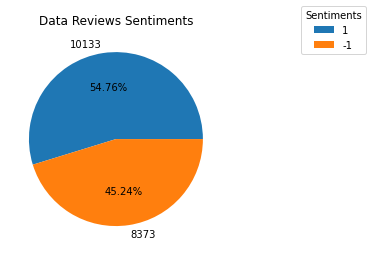

In [27]:
sentiments= Counter(test_pred).keys()
sentiments_count= Counter(test_pred).values()
plt.pie(sentiments_count,labels= sentiments_count,autopct= "%1.2f%%")
plt.legend(sentiments,title= "Sentiments",loc= "center",bbox_to_anchor= (1, 0, 1, 2))
plt.title("Data Reviews Sentiments")
plt.show()